# Deep Learning: common issues and solutions

This notebook presenting various techniques must be handed in. It will be marked.
You must add your own comments and tests. It is the comments and your own tests that will be assessed.
* Commentary when comparing different approaches
* Own test, when testing different parameters

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model 

In [5]:
#!pip install keras-tuner --upgrade
import keras_tuner

In [6]:
### Some global constant
epochs=100
batch_size=256
patience=10
hidden_dim=256

In [7]:
### Usual function for babysit the network

# It is important to systematically observe the learning curves
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

In [8]:
### Usual callback for training deep learning model

# It is important to use early stopping systematically
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True)]

## 1. Today lab

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)

As you did in the previous lab, the goal is to try to predict the 'Rating' after reading the 'Reviews'.
We will mostly use this dataset as a case study to illustrate issues that you can have using Multilayer Perceptron or other Deep Learning architectures, namely:

1) **Text preprocessing with Tensorflow API**

2) **The vanishing gradient problem**:

Problem: Your model does not learn at all !
    
3) **Underfitting and Overfitting problems**
Problems:

    - Underfitting relates to the fact that your model does not learn enough on the train dataset to hope for good generalization abilities (good label prediction on new samples with unknown labels).
    - Overfitting means that your model fits too much to the train dataset, which can also prevents it from generalizing well to new samples with unknown labels.
    
4) **Starting, stopping, and resuming training**

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! 

5) Find best hyper-parameters with keras-tuner

## 2. Dataset pre-processing

In this lab, we will just re-use the dataset of previous lab providing Sentiment Analysis tasks. 
And we will stick to the tf-idf approach for word embeddings. 

### a) Essential reminder [About Train, validation and test sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
![test/train/val](https://miro.medium.com/max/1466/1*aNPC1ifHN2WydKHyEZYENg.png)

* **Training Dataset:** The sample of data used to fit the model.
* **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

**If you use cross validation, concatenate Train and Validation set.**

In [9]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


### b) Build X (features vectors) and y (labels)

In [10]:
# Construct X_train and y_train
X_train = TRAIN['Reviews'].fillna("")
#print(X_train)
X_train = np.array(TRAIN['Reviews'].fillna("")).reshape(-1,1)
#print(X_train)
y_train = TRAIN['Rating']
y_train = np.array(TRAIN['Rating']).reshape(-1,1)
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [11]:
# Construct X_test and y_test
X_test = TEST['Reviews'].fillna("")
X_test = np.array(TEST['Reviews']).reshape(-1,1)
y_test = TEST['Rating']
y_test = np.array(TEST['Rating']).reshape(-1,1)

X_test.shape, y_test.shape

((1000, 1), (1000, 1))

In [12]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
#y_val_encoded = ohe.transform(y_val) #No need to use here
y_test_encoded = ohe.transform(y_test)

In [13]:
# Define constant
n_classes = len(np.unique(y_train))
feature_vector_length = X_train.shape[1]

feature_vector_length, n_classes

(1, 5)

## 3. Text preprocessing with tensorflow

So far we have used `sklearn.feature_extraction.text.CountVectorize` or `sklearn.feature_extraction.text.TfidfVectorize` preceded by our own preprocessing to transform a text sequence into a vector. Unfortunately it is not possible to integrate this into a 'tensorflow' pipeline or vice versa, integrating a Tensorflow network into a sklearn pipeline is not easy. 

Fortunately, Tensorflow has a similar function: [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

Look at the Tensorflow documentation to understand how it works.

The main parameter is output_mode:
* "int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.
    * give an ID for each token
    
Below is a small example of use

In [14]:
corpus = ["I love chocolate and I hate beer",
          "I love beer and I hate chocolate",
          "I love beer and I love chocolate"]
corpus = tf.convert_to_tensor(corpus)

for output_mode in ['multi_hot', 'count', 'tf_idf', 'int']:
    print("-"*50)
    print("output_mode:", output_mode)
    vectorize_layer = layers.TextVectorization(output_mode=output_mode)
    vectorize_layer.adapt(corpus) # Do the same thinks as fit in sklearn library
    print(vectorize_layer.get_vocabulary())
    print(vectorize_layer(corpus))

--------------------------------------------------
output_mode: multi_hot
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 0.]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: count
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0. 2. 1. 1. 1. 1. 1.]
 [0. 2. 1. 1. 1. 1. 1.]
 [0. 2. 2. 1. 1. 1. 0.]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: tf_idf
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'hate']
tf.Tensor(
[[0.        1.1192316 0.5596158 0.5596158 0.5596158 0.5596158 0.6931472]
 [0.        1.1192316 0.5596158 0.5596158 0.5596158 0.5596158 0.6931472]
 [0.        1.1192316 1.1192316 0.5596158 0.5596158 0.5596158 0.       ]], shape=(3, 7), dtype=float32)
--------------------------------------------------
output_mode: int
['', '[UNK]', 'i', 'love', 'chocolate', 'beer', 'an

<font color="red">[TO DO STUDENTS]</font>

It is up to you to build examples with the other parameters of the TextVectorization function

In [15]:
#""" Your code here """

#ADAPT means fit for vectorize_layer

#Initialize the corpus
corpus = ["I love chocolate and I hate beer",
          "I love beer and I hate chocolate",
          "I love beer and I love chocolate"]
corpus = tf.convert_to_tensor(corpus)

#Creating lists of parameters in order to try them
output_mode_list=['multi_hot', 'count', 'tf_idf', 'int']
ngrams_list=[(1,3),(2,4)] #Try only 1 and 3 here but in sklearn it does 1,2,3 (for the 1st tuple)
split_list=['whitespace','character']

for output_mode in output_mode_list: #Will compare the differents output modes
    print("-"*25,output_mode,"-"*25)
    for split in split_list:
        print("-"*25,"split :",split,"-"*25) #will compare differents splits
        for ngram in ngrams_list: #Will compare differents ngrams
            print("-"*25,"ngram :",ngram,"-"*25)
            print("output_mode:", output_mode)
            vectorize_layer = layers.TextVectorization(output_mode=output_mode,ngrams=ngram,split=split)
            vectorize_layer.adapt(corpus) # Do the same thing as fit in sklearn library
            print(vectorize_layer.get_vocabulary())
            print(vectorize_layer(corpus))




------------------------- multi_hot -------------------------
------------------------- split : whitespace -------------------------
------------------------- ngram : (1, 3) -------------------------
output_mode: multi_hot
['[UNK]', 'i', 'love', 'chocolate', 'beer', 'and', 'love beer and', 'i love chocolate', 'i love beer', 'hate', 'beer and i', 'and i hate', 'love chocolate and', 'i hate chocolate', 'i hate beer', 'chocolate and i', 'and i love']
tf.Tensor(
[[0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]], shape=(3, 17), dtype=float32)
------------------------- ngram : (2, 4) -------------------------
output_mode: multi_hot


['[UNK]', 'i love', 'and i', 'love chocolate', 'love beer and i', 'love beer', 'i love beer and', 'i hate', 'beer and', 'love chocolate and i', 'i love chocolate and', 'hate chocolate', 'hate beer', 'chocolate and i hate', 'chocolate and', 'beer and i love', 'beer and i hate', 'and i love chocolate', 'and i hate chocolate', 'and i hate beer']
tf.Tensor(
[[0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]], shape=(3, 20), dtype=float32)
------------------------- split : character -------------------------
------------------------- ngram : (1, 3) -------------------------
output_mode: multi_hot
['[UNK]', ' ', 'e', 'o', 'a', 'l', 'i', 'c', 't', 'h', 'a t e', 'v e  ', 'v', 'o v e', 'l o v', 'i   l', '  l o', 't e  ', 'r', 'o l a', 'o c o', 'n d  ', 'n', 'l a t', 'h o c', 'e e r', 'e   c', 'e   b', 'd   i', 'd', 'c o l', 'c h o', 'b e e', 'b', 'a n d', '  

<font color="red">[ TO DO STUDENTS]</font>

Initialize your vectorizer layer according to the training data

In [16]:
#""" Your code here """
#Output mode is tf_idf as we should stick with this approach
vectorizer = layers.TextVectorization(output_mode='tf_idf',
                                      ngrams=1,
                                     )
vectorizer.adapt(X_train.ravel())

## 3. Vanishing gradient problem

This problem can be encountered when training NN with gradient-based learning methods and backpropagation. In such methods, during each iteration of training each of the neural network's weights receives an update proportional to the partial derivative of the loss function with respect to the current weight. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. This mostly occurs when your architecture counts too many parameters to learn.

Possible solutions, obviously with their pros and cons: 

* Reduce the depth of your network.
* Use sparsity promoting activation functions such as the ReLU activation function, i.e ReLU(x)= max(0, x)
* Use residual connections, i.e output at each layer: layer(input) + input
* Use normalization techniques, e.g Batch Normalization and so on.

### a) Observe the vanishing gradient problem

<font color="red">[ TO DO STUDENTS]</font>

Design a function to simply build MLP with the following inputs, which return the model ready to compile:

* vectorizer: the vectorizer layer used to transform a sentence in a vector</font>
* activation: activation used at each hidden layer
* n_hiddenlayers: number of hidden layers in the network
* hidden_dim: shared number of neurons within each hidden layer

In [17]:
np.unique(y_train)

array([1, 2, 3, 4, 5])

In [18]:
def build_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    
    #""" Your code here """
    
    #shape should be X_train.shape[1]
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    
    hidden_layer = vectorizer(input_layer)
    
    #hidden layers
    for i in range(n_hiddenlayers):
        #hidden_dim is the number of neurons in each hidden layer
        hidden_layer = layers.Dense(hidden_dim, activation=activation)(hidden_layer)
    
    #Dense parameter should be np.unique(y_train) (classes): 
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(hidden_layer)
    model = Model(inputs=input_layer, outputs=output_layer) 
    
    return model

In [19]:
# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorizer, 'tanh', 30, hidden_dim)

In [20]:
# Print the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_20 (Text  (None, 11001)            1         
 Vectorization)                                                  
                                                                 
 dense (Dense)               (None, 256)               2816512   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                             

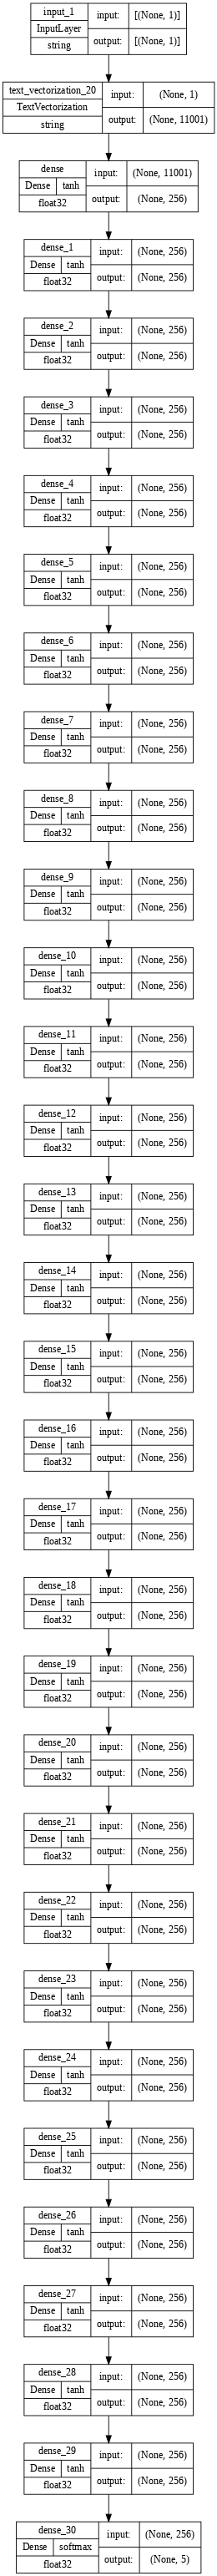

In [21]:
#Plot the model
import graphviz
import pydot

plot_model(model, 
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)


<font color="red">You now know 2 ways to view your network. You can choose the one you prefer.</font>

In [22]:
# Configure the model and start training, use the defined early stopping
#early stopping = callbacks_list


#""" your code here """

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,
                  verbose=1,
                  validation_split=0.2,
                  callbacks=callbacks_list,
                 )
                  


Epoch 1/200
32/32 [==============================] - 12s 250ms/step - loss: 1.4310 - accuracy: 0.4890 - val_loss: 1.3080 - val_accuracy: 0.5530
Epoch 2/200
32/32 [==============================] - 4s 121ms/step - loss: 1.3287 - accuracy: 0.5320 - val_loss: 1.3597 - val_accuracy: 0.5520
Epoch 3/200
32/32 [==============================] - 3s 96ms/step - loss: 1.3168 - accuracy: 0.5322 - val_loss: 1.2794 - val_accuracy: 0.5510
Epoch 4/200
32/32 [==============================] - 3s 97ms/step - loss: 1.3260 - accuracy: 0.5330 - val_loss: 1.2884 - val_accuracy: 0.5510
Epoch 5/200
32/32 [==============================] - 3s 96ms/step - loss: 1.3071 - accuracy: 0.5320 - val_loss: 1.2872 - val_accuracy: 0.5510
Epoch 6/200
32/32 [==============================] - 3s 95ms/step - loss: 1.3011 - accuracy: 0.5322 - val_loss: 1.3017 - val_accuracy: 0.5520
Epoch 7/200
32/32 [==============================] - 3s 99ms/step - loss: 1.3079 - accuracy: 0.5337 - val_loss: 1.2915 - val_accuracy: 0.5520
Epo

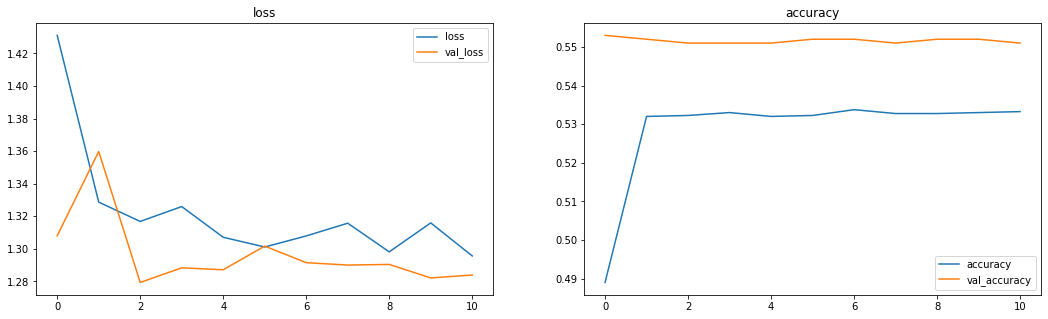

In [23]:
# Plot the learning curves and analyze them
#""" your code here """
babysit(history.history)


We can see that both accuracies are almost constant after a small increase, so we can say that the model is not learning

<font color="red">[ TO DO STUDENTS]</font>

Is your network learning? Check your intuition by evaluating your model and looking at the confusion matrix.

In [24]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:',test_loss)


32/32 [==============================] - 0s 14ms/step - loss: 1.2848 - accuracy: 0.5560
Test accuracy: 0.5559999942779541
Test loss: 1.2848103046417236


32/32 [==============================] - 1s 19ms/step


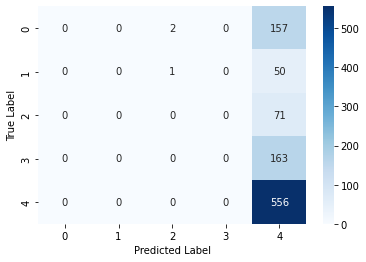

In [25]:
# Print/plot the confusion matrix
#""" your code here """
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

As said before, we can see a constant accuracy, its not increasing, the model does not learn

The confusion matrix shows that that the classes were predicted corectly, only the last class have an approximately good accuracy, an other proof that the model is not learning

### b) Experiment on ReLU activation

<font color="red">[ TO DO STUDENTS]</font>

Change activation from 'tanh' to 'relu', still with a deep network.

In [26]:
# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorizer, 'relu', 30, hidden_dim)

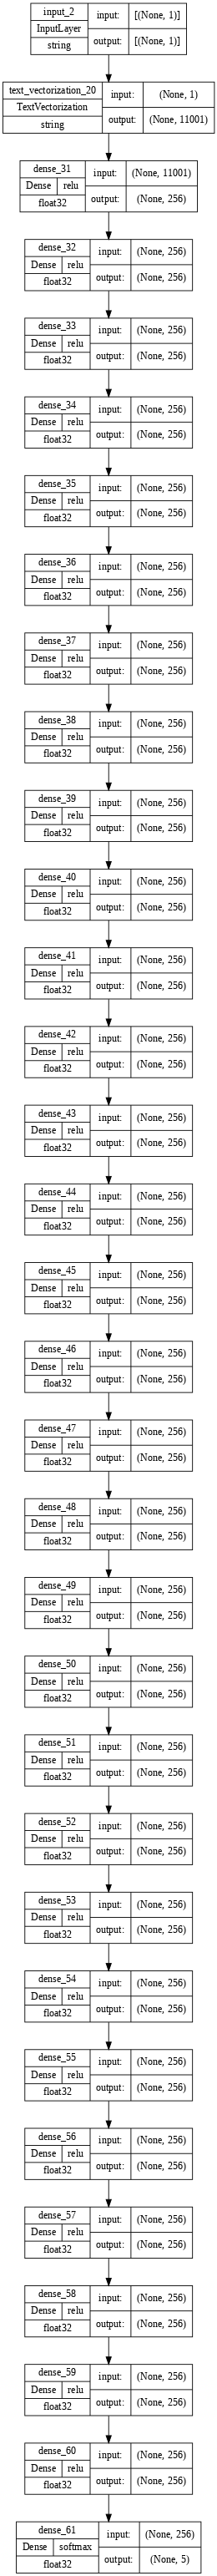

In [27]:
plot_model(model, 
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

In [28]:
# Configure the model and start training
# """ your code here """
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


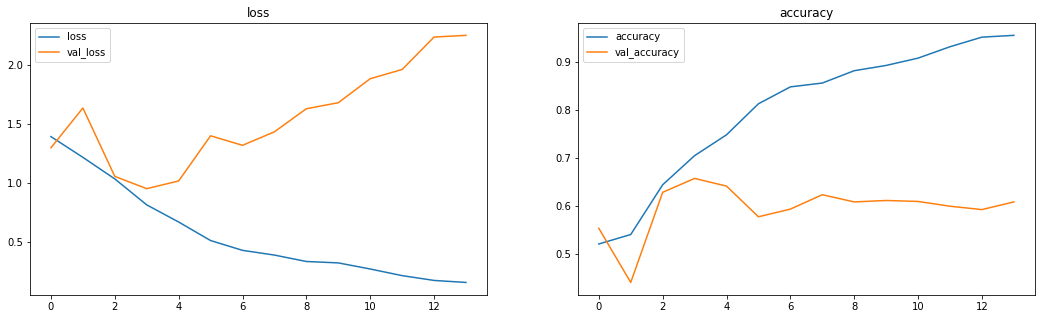

In [29]:
# Plot the learning curves and analyze them
#""" your code here """
babysit(history2.history)


32/32 [==============================] - 1s 13ms/step


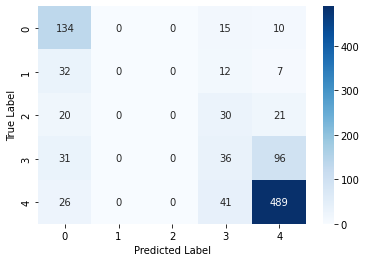

In [30]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

We can see that the networks learns much better, we have a better accuracy but the val_accuracy is still constant so the network learns very badly for validation set.
The confusion matrix shows us that we have an evolution, this time, we have more true predictions.
ReLu helped a litle but it still a bad network and the model still struggles to learn and get good performance on the validation set

<font color="red">[ TO DO STUDENTS]</font>

Does the network learn better? Does the network perform well? Study the learning curves and justify your statements with the study of its performance (classification report and confusion matrix)

On my code, it seems that the ReLU activation for sparsity has helped to solve the problem, but the model still struggles to learn and to get good performance on the validation set.

### c) Experiment on residual connections

<font color="red">[ TO DO STUDENTS ]<color>
* Create a function to generate models with residual connections.
* Using ReLU activation + residual connections, are you able to get better results ?
* Provide here a description of the learning and performances of your network
* Compare it to previous models. What are your conclusions ?

In [31]:
#sources : https://medium.com/swlh/how-to-create-a-residual-network-in-tensorflow-and-keras-cd97f6c62557

def build_residual_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    #""" your code here """
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    x=vectorizer(input_layer)    
    x_begin = layers.Dense(hidden_dim, activation=activation)(x)

    for i in range(n_hiddenlayers):
  
        x = layers.Dense(hidden_dim, activation=activation)(x)
    x = layers.add([x_begin, x])
        
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer) 
    
    return model



In [32]:
# Build a network with 30 hidden layers with 'relu' activations
model = build_residual_model(vectorizer, 'relu', 30, hidden_dim)

In [33]:
# Print and plot the model --> What is the best solution ?
#Print : 
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_20 (TextVec  (None, 11001)       1           ['input_3[0][0]']                
 torization)                                                                                      
                                                                                                  
 dense_63 (Dense)               (None, 256)          2816512     ['text_vectorization_20[2][0]']  
                                                                                                  
 dense_64 (Dense)               (None, 256)          65792       ['dense_63[0][0]']         

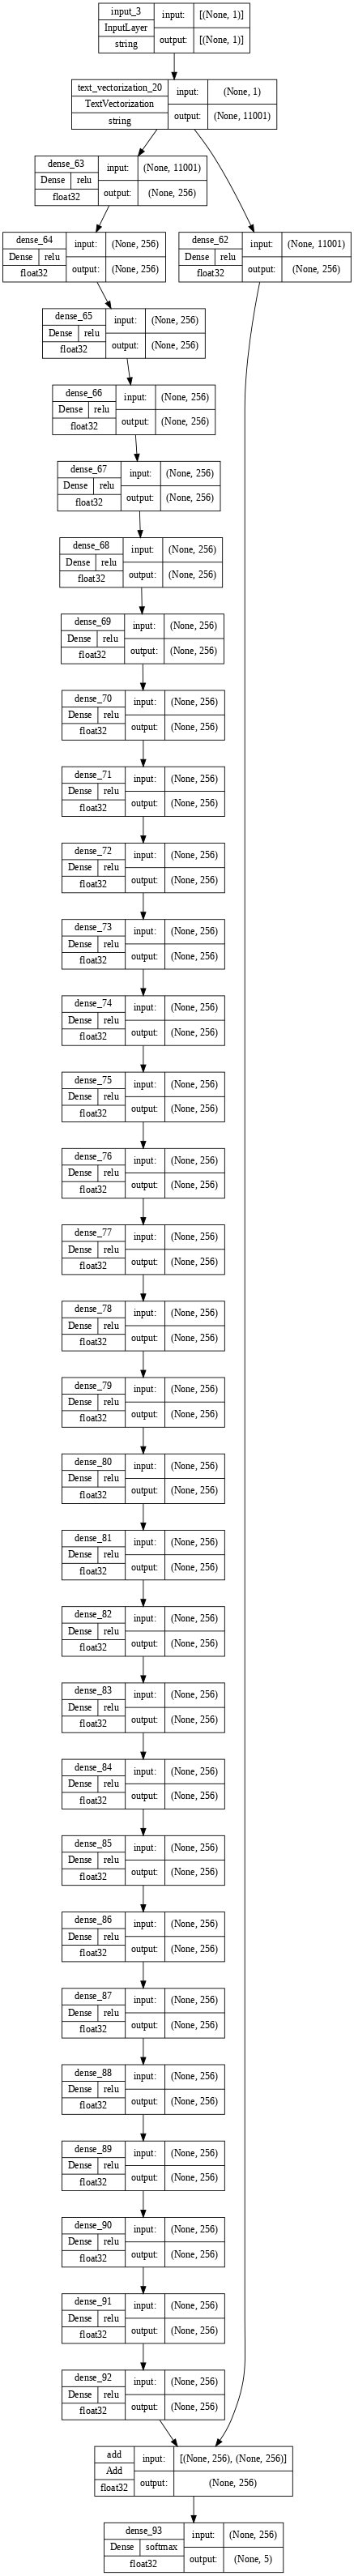

In [34]:
#Plot : 
plot_model(model, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

In [35]:
# Configure the model and start training
#""" your code here """
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)



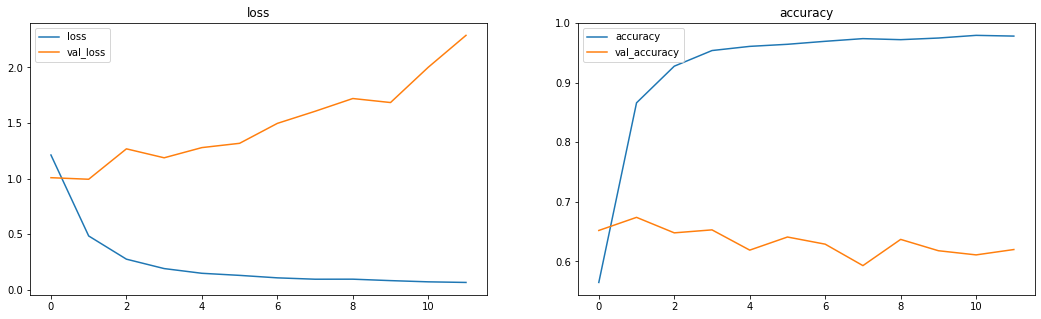

In [36]:
# Plot the learning curves and analyze them

#""" your code here """
babysit(history.history)

In [37]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:',test_loss)


32/32 [==============================] - 1s 19ms/step - loss: 0.9889 - accuracy: 0.6860
Test accuracy: 0.6859999895095825
Test loss: 0.9888585805892944


32/32 [==============================] - 1s 19ms/step


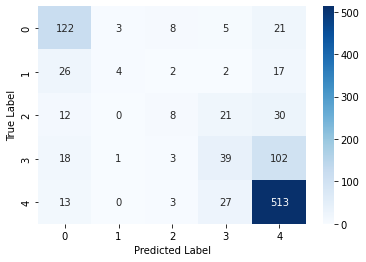

In [38]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


The networks works well better for the training set with an accuracy close to 1 but the val_acc is constant and very bad, it is a case of overfiting. Also, the val_loss is increasing a lot

### d) Experiment on Batch Normalization

<font color="red">[ TO DO STUDENTS ]</font>
* step1: adapt build_model function to add batch normalization layers after the output of the hidden dense layers. 
* step2: adapt build_model function to use batch normalization layers and residuals
             
* In both case use ReLU activation and 30 hidden layers as previouly
* Compare your results

In [39]:
def build_model_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    #""" Your code here """
    
        
    #shape should be X_train.shape[1]
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    
    hidden_layer = vectorizer(input_layer)
    
    
    #adding Dense
    for i in range(n_hiddenlayers):
        hidden_layer = layers.Dense(hidden_dim, activation=activation)(hidden_layer)
        #batch normalization
        hidden_layer = layers.BatchNormalization()(hidden_layer)
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(hidden_layer)
    model = Model(inputs=input_layer, outputs=output_layer) 
    
    return model

In [40]:
def build_residual_model_residual_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    #""" your code here """
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    x=vectorizer(input_layer)    
    x_start = layers.Dense(hidden_dim, activation=activation)(x)

    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
    x = layers.add([x_start, x])
    
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer) 
    
    return model

In [41]:
#Build and train the network with BatchNormalization layer
model = build_model_batch_normalization(vectorizer, 'relu', 30, hidden_dim)

# Configure the model and start training
#""" your code here """

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)

#reference : https://www.researchgate.net/post/How_to_tackle_the_problem_of_constant_val_accuracy_in_CNN_model_training

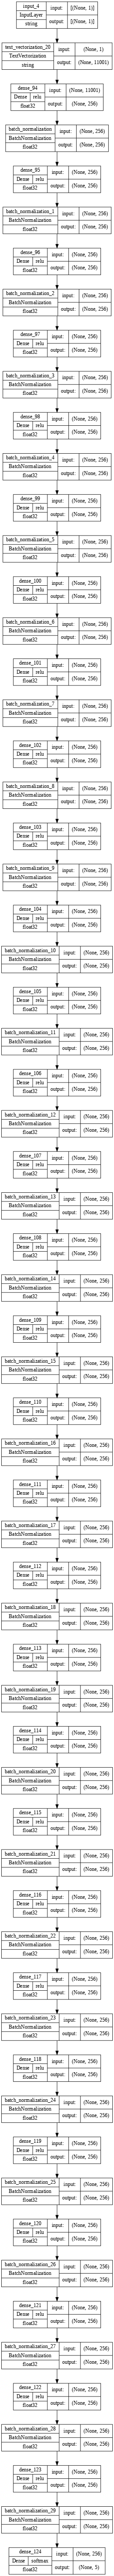

In [42]:
plot_model(model, 
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)


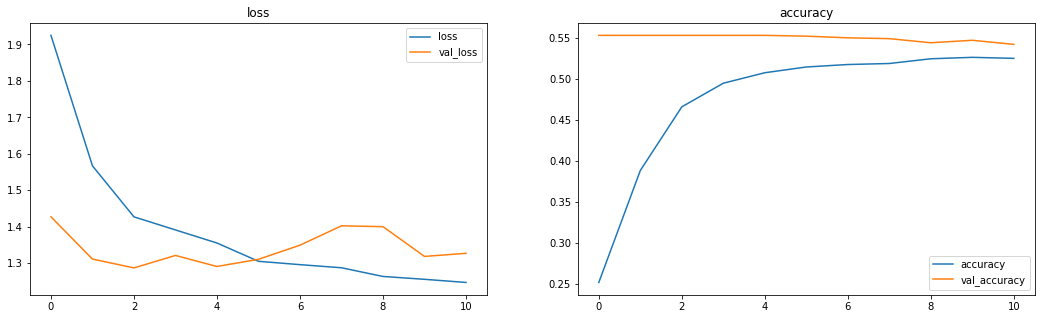

In [43]:
# Plot the learning curves and analyze them
#""" your code here """
babysit(history.history)

32/32 [==============================] - 1s 16ms/step


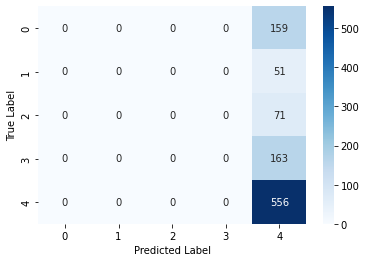

In [44]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Here, we can see with the confusion matrix that we have again the same problem than in the first model with less well predicted classes.
And the model is not learning enough, it is not a good model, the val accuracy is better than accuracy, which means the model has kind of generalizred well but its still not a good model.

In [45]:
# Do the same with `build_residual_model_residual_batch_normalization`
#""" your code here """

#Build and train the network with BatchNormalization layer
model = build_residual_model_residual_batch_normalization(vectorizer, 'relu', 30, hidden_dim)

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_20 (TextVec  (None, 11001)       1           ['input_5[0][0]']                
 torization)                                                                                      
                                                                                                  
 dense_126 (Dense)              (None, 256)          2816512     ['text_vectorization_20[4][0]']  
                                                                                                  
 batch_normalization_30 (BatchN  (None, 256)         1024        ['dense_126[0][0]']        

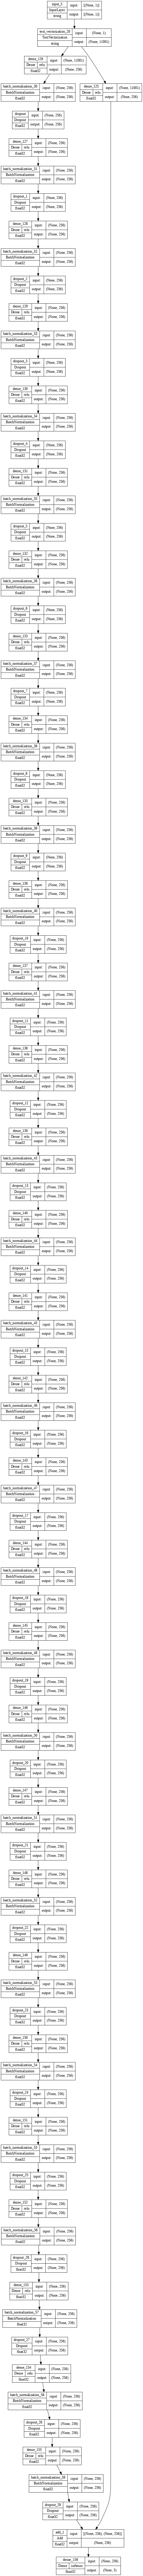

In [46]:
plot_model(model, 
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)


![image.png](attachment:image.png)

In [47]:
# Configure the model and start training

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


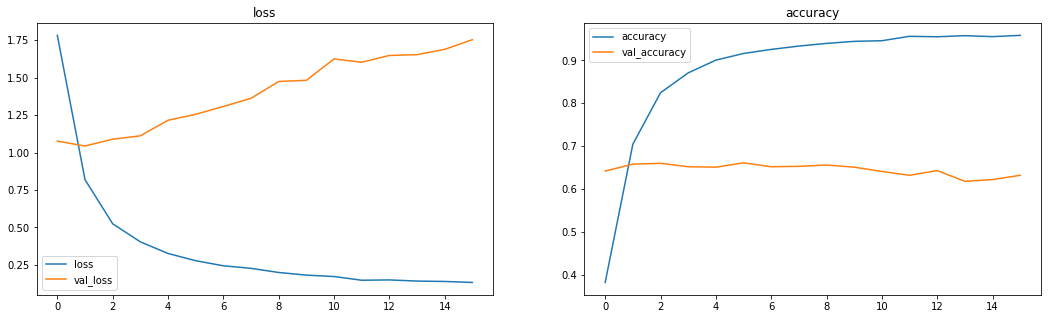

In [48]:
babysit(history.history)

32/32 [==============================] - 2s 21ms/step


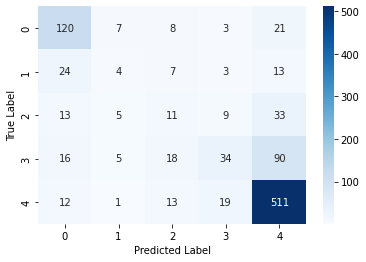

In [49]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Here, with the confusion matrix and the history, we can see that the plot is learning way better with the train data with an accuracy increasing up to more than 0.9.
Unfortunately, there is still a problem with the validation accuracy, it does not increase but it is better

### e) What if you simply reduce the network depth ?

<font color="red">[ TO DO STUDENTS ]</font>
* build a MLP with ReLU activation composed of 10 hidden layers
* compare your results both in terms of learning and performances compared to other models

In [50]:
#Build and train the network without residual connections
model = build_model(vectorizer, 'relu', 10, hidden_dim)

In [51]:
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_20 (Text  (None, 11001)            1         
 Vectorization)                                                  
                                                                 
 dense_157 (Dense)           (None, 256)               2816512   
                                                                 
 dense_158 (Dense)           (None, 256)               65792     
                                                                 
 dense_159 (Dense)           (None, 256)               65792     
                                                                 
 dense_160 (Dense)           (None, 256)               65792     
                                                           

In [52]:
# Configure the model and start training
#""" your code here """
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


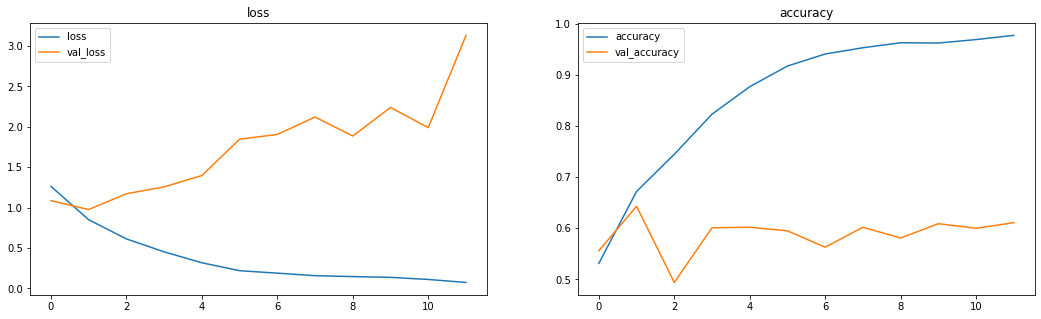

In [53]:
# Plot the learning curves and analyze them
#""" your code here """

#references : https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
babysit(history.history)
#We can see an example of overfitting because the loss is decreasing a lot

32/32 [==============================] - 1s 13ms/step


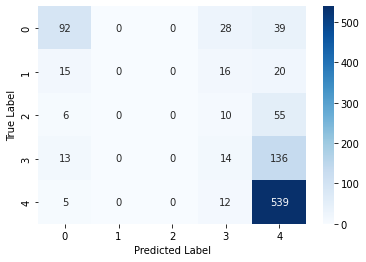

In [54]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Here, we again have a very good train accuracy but a poor validation accuracy (the validation accuracy is not the worse but we have a huge difference between acc and val_acc), this means that we have a again case of overfiting.
It can be because we use a too much complex model for this problem.

Normally, you observed a typical instance of overfitting.

## 4.  Underfitting and Overfitting problems

Actually what you observed in the last experiment is a typical instance of overfitting.

### a) Decrease the network size ?

In [55]:
#Build and train the network without residual connections
model = build_model(vectorizer, 'relu', 5, hidden_dim)

In [56]:
# Configure the model and start training
#""" your code here """
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


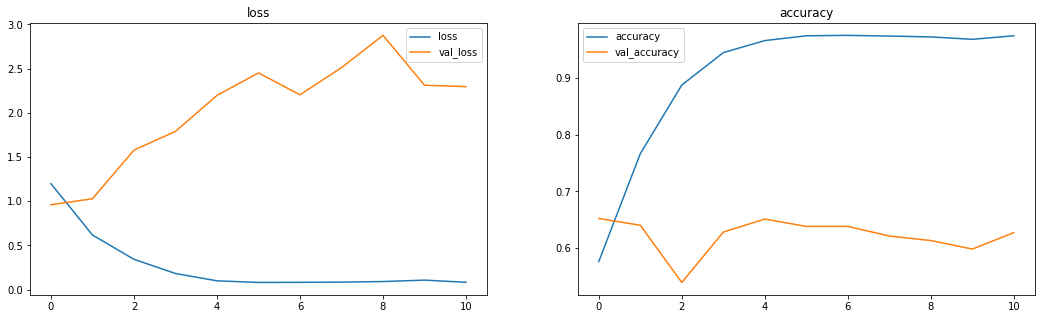

In [57]:
# Plot the learning curves and analyze them
#""" your code here """
babysit(history.history)


For me: it gets slightly better but almost the same behavior is observed when taking 10 and 5 hidden layers.

What's going on for you ?

The loss is still decreasing but we can see that the accuracy has increased a lot, the model is learning better but not for the validation set


### b) Experiment on L2 regularization

<font color="red">[ TO DO STUDENTS ]</font>
* check the keras documentation on regularizations https://keras.io/api/layers/regularizers/
* Add to the previous network L2 regularization: first with l2_reg = 0.01 / then with l2_reg= 0.0001
* Compare results

In [58]:
# Design the model function
from tensorflow.keras import regularizers

def build_model_reg(vectorizer, activation, n_hiddenlayers, hidden_dim, l2_reg = 0.01):
    #""" your code use: kernel_regularizer and bias_regularizer parameters of Dense"""
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    
    hidden_layer = vectorizer(input_layer)
    
    for i in range(n_hiddenlayers):
        hidden_layer = layers.Dense(hidden_dim,
                                    activation=activation,
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=l2_reg),                    
                                    bias_regularizer=regularizers.L2(l2_reg)
                                   )(hidden_layer)
    
    #Dense parameter should be np.unique(y_train) : 
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(hidden_layer)
    model = Model(inputs=input_layer, outputs=output_layer) 
    
    return model


In [59]:
#Build and train the network without residual connections
model = build_model_reg(vectorizer, 'relu', 5, hidden_dim, 0.01)


In [60]:
# Configure the model and start training
#""" your code here """
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


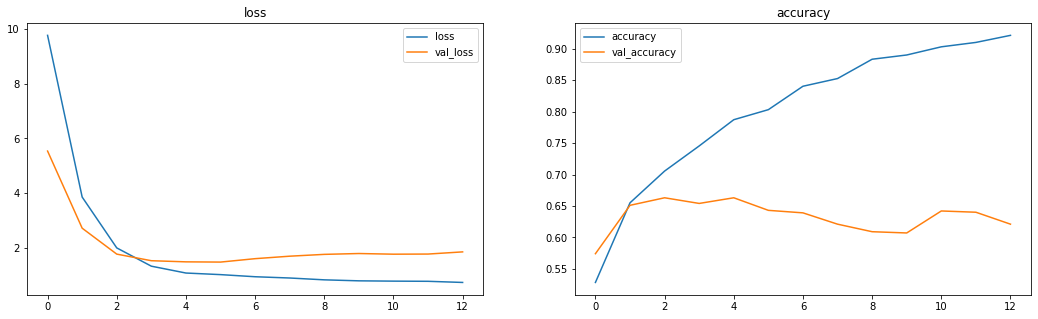

In [61]:
# Plot the learning curves and analyze them
# """ your code here """
babysit(history.history)

#we can see a better evolution of loss and accuracy

32/32 [==============================] - 1s 11ms/step


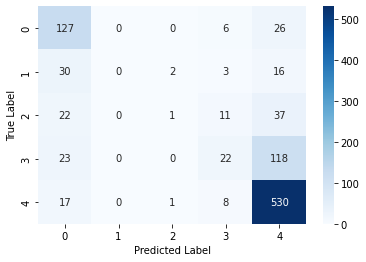

In [62]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

<font color="red">[ TO DO STUDENTS]</font code="red">

Reduce the coefficient of L2 regularization taken into account in the loss from l2_reg = 0.01 > to l2_reg = 0.0001 and do the same experimentation.

In [63]:
# """ your code here """
model = build_model_reg(vectorizer, 'relu', 5, hidden_dim, 0.0001)

In [64]:
# Configure the model and start training

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


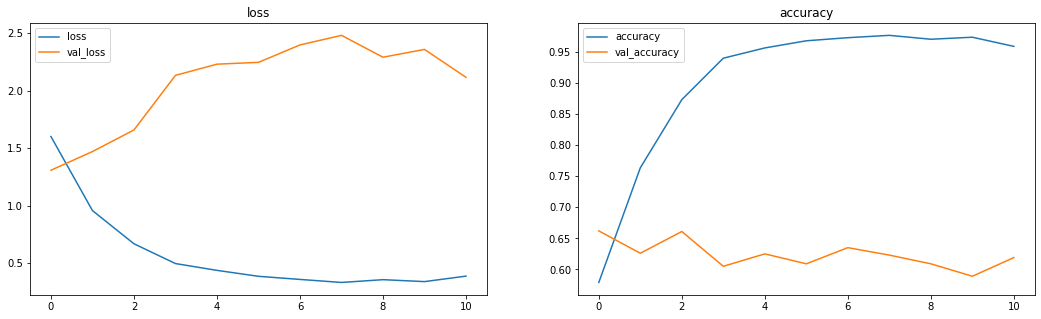

In [65]:
babysit(history.history)


32/32 [==============================] - 0s 9ms/step


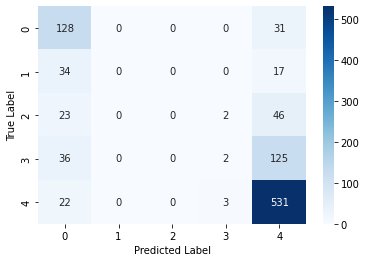

In [66]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

What is your conclusion ?

I could not managed to be bring the model to be strong enough to learn for validation set but the accuracy of the training data has became very good and the networks learn much better

### c) Experiment on Dropout

<font color="red">[TO DO STUDENTS]</font>
* Observe the provided results for a dropout ratio of p=0.7 and p=0.3
* What are your conclusions ?
* In the end, considering all the explored settings in this Lab, what would you suggest as a network to get a better model ?

In [67]:
# Design the model function
from keras.layers import Dropout

def build_model_dropout(vectorizer, activation, n_hiddenlayers, hidden_dim, p = 0.5):
#     """ your code here """

    #""" your code use: kernel_regularizer and bias_regularizer parameters of Dense"""
    l2_reg = 0.01
    
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    
    hidden_layer = vectorizer(input_layer)
    for i in range(n_hiddenlayers):
        hidden_layer = layers.Dense(hidden_dim,
                                    activation=activation,
                                    bias_regularizer=regularizers.L2(l2_reg),
                                    kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=l2_reg)
                                   )(hidden_layer)
        

        hidden_layer = layers.Dropout(p)(hidden_layer)

    
    #Dense parameter should be np.unique(y_train) : 
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(hidden_layer)
    model = Model(inputs=input_layer, outputs=output_layer) 
    


    return model



In [68]:
# Build and train the network without residual connections
model = build_model_dropout(vectorizer, 'relu', 5, hidden_dim, 0.7)

In [69]:
# Configure the model and start training
# """ your code here """

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


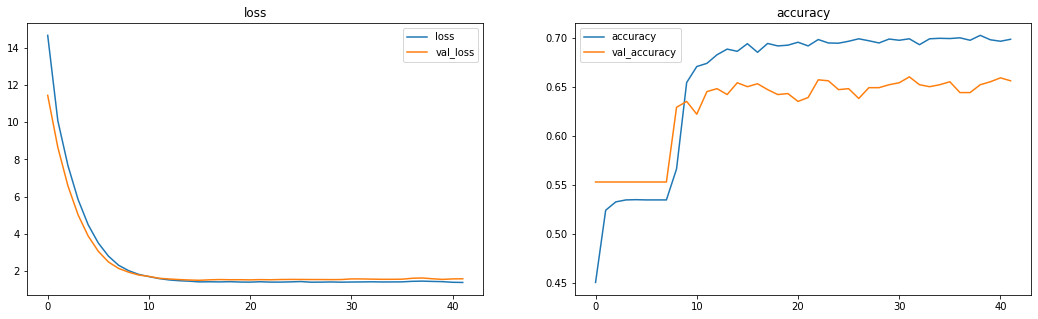

In [70]:
# Plot the learning curves and analyze them
# """ your code here """
babysit(history.history)


32/32 [==============================] - 0s 8ms/step


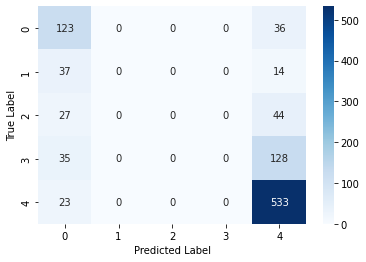

In [71]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Here, we can see a good evolution of the accuracy for training and validation set, which is a very good thing. However, the confusion matrix tell us that the model is still bad and it has not a good prediction for every classes.
It is the best network so far. However, the accuracy of training set has decreased

<font color="red">[ TO DO STUDENTS]</font code="red">

Decrease the proportion of neurons deactivated at each forward pass, from 0.7 to 0.3

In [72]:
# Build and train the network without residual connections
model = build_model_dropout(vectorizer, 'relu', 5, hidden_dim, 0.3)

In [73]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train_encoded, epochs=200,batch_size=128,verbose=0,validation_split=0.2,callbacks=callbacks_list)


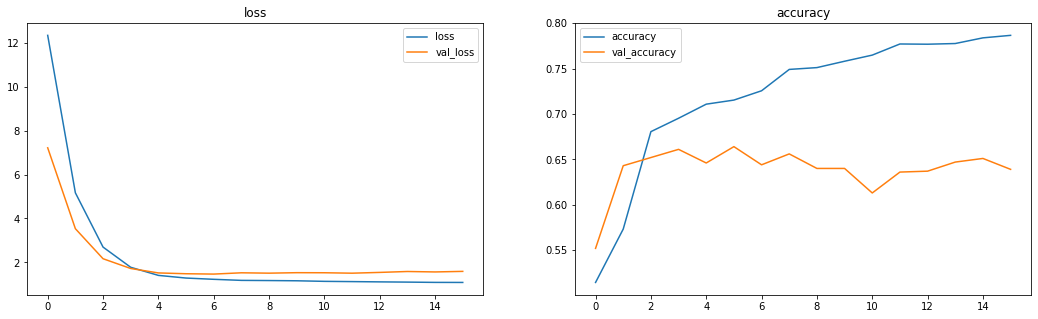

In [74]:
babysit(history.history)

32/32 [==============================] - 1s 12ms/step


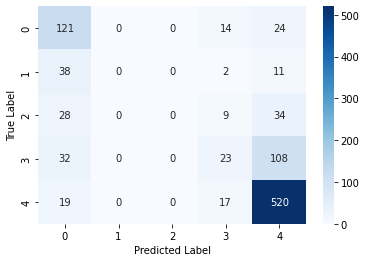

In [75]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Here, we still have a good learning with a better training accuracy, but the validation accuracy tends to stagnate, which is a result of a litle overfiting

What is your conclusion ?

## Stop and resume training

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! Fortunately, there is a solution - but when these situations occur, you need to know what to do:

1. Take a snapshot model that was saved/serialized to disk during training.
1. Load the model into memory.
1. Resume training where you left off.

Starting, stopping and resuming training is standard practice when setting the learning rate manually:

1. Start training your model until the loss/accuracy reaches a plateau.
1. Take a snapshot of your model every N epochs (typically N={1, 5, 10})
1. Stop training when you arrive at a plateau (by forcing out via ctrl + c or via earlystopping
1. Adjust your learning rate (typically by reducing it by an order of magnitude).
1. Restart the training script, starting from the last snapshot of the model weights

The ability to adjust the learning rate is an essential skill for any deep learning practitioner to master, so take the time to study and practice it!

<font color="red">Look at the documentation Tensorflow has proposed for ModelCheckpoint: we want to save the model at the end of each epoch so that we can restore it later.</font>

In [76]:
#In order to prevent warning :
import logging
logging.getLogger("absl").setLevel(logging.ERROR)

In [77]:
# Reuse one the previous model and reset it
# Use sgd as optimizer and fix learning_rate = 0.1
# Use 2 callbacks : EarlyStopping and ModelCheckpoint
# Save model at each epoch
# Fit the network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_model_dropout(vectorizer, 'relu', 5, hidden_dim, 0.5)

checkpoint_filepath = 'issue_and_sol_checkpoint'
opt = optimizers.SGD(learning_rate=0.1) # Fix learning rate to 0.1
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True),
                                ModelCheckpoint(
                                    filepath=checkpoint_filepath,
                                    save_freq='epoch',
                           
                                   # Complete, if necessary
                                 )
                 ]

history1 = model.fit(X_train, y_train_encoded, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)



#reference : https://stackoverflow.com/questions/61046870/how-to-save-weights-of-keras-model-for-each-epoch

In [78]:
# Re-load the model
new_model = tf.keras.models.load_model(checkpoint_filepath)

What is the difference between load_model and load_weights ?

If you load a model through load, you will have a model identical to the one you have saved included the optimizer state.

If you load the model through load_weights is used to load only the weight of a model.

---



In [79]:
# Change learning_rate = 0.01
new_model.optimizer.lr.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [80]:
# Continue to fit the network

history2 = new_model.fit(X_train, y_train_encoded, validation_split=0.2,
                         epochs=epochs, batch_size=batch_size,
                         callbacks=callbacks_list, verbose=0)




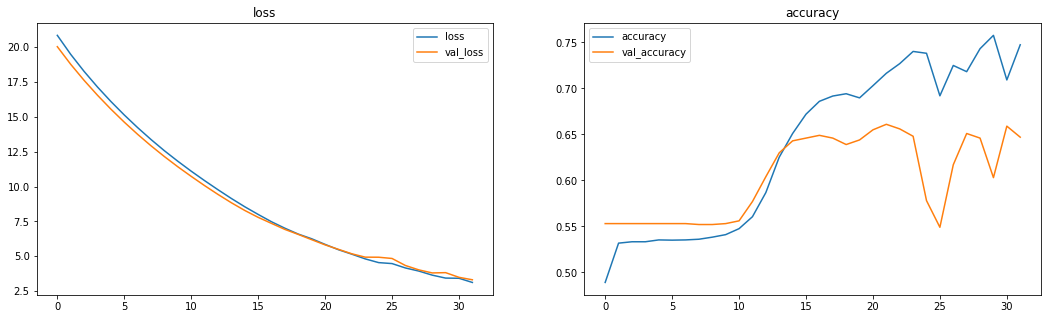

In [81]:
#Let's look at both our model before and after reloading
#Before :
babysit(history1.history)

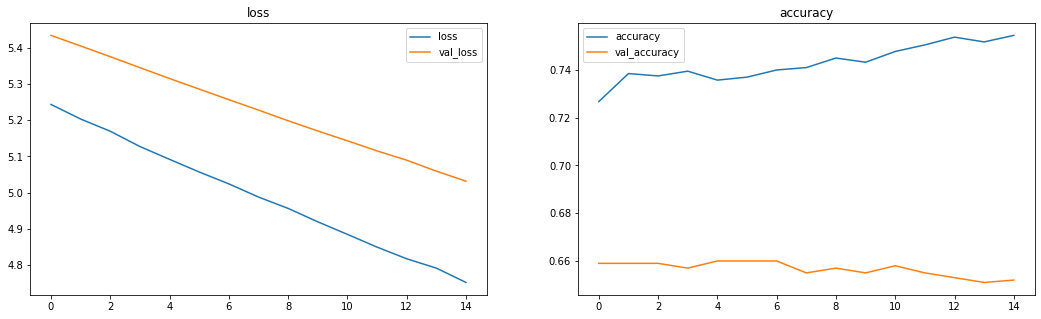

In [82]:
#After :
babysit(history2.history)

It means nothing to compare both of history together but we can see that the model continue to learn after reloading and its a good thing
but the learning changed as we changed the learning rate, its not learning like previously.
However, the val_accuracy did not continue to increase

## Use Keras-tuner

<font color="red">[TO DO STUDENTS]</font>

From the previous experiences use Keras-tuner to find the best possible network.

Keras-Tuner must build at least 3 different network architectures:
* Dense cells only
* Addition of residuals
* Adding batch normalisation
* Adding dropout
* A combination of the different additions


In [92]:
# """ your code here """

#references :
#https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
#https://keras.io/keras_tuner/

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the model building function
def build_model(hyper_param):
    input_layer = layers.Input(shape=(X_train.shape[1]), dtype=tf.string)
    
    x = vectorizer(input_layer)
    #x = layers.Dense(hidden_dim, activation=activation)(x)

#Dense cell only
    for i in range(hyper_param.Int('n_dense_layers', 1, 30)):
        x = layers.Dense(hyper_param.Int('dense_units_' + str(i), 32, 256, 32), activation='relu')(x)
    
#Residual choice
    if hyper_param.Choice('residual', ['yes', 'no']) == 'yes':
        x = layers.add([x, x])
    
#Batch normalization choice
    if hyper_param.Choice('batch_norm', ['yes', 'no']) == 'yes':
        x = layers.BatchNormalization()(x)
    
    if hyper_param.Choice('dropout', ['yes', 'no']) == 'yes':
        x = layers.Dropout(hyper_param.Float('dropout_rate', 0, 0.7, step=0.1))(x)
    
    output_layer = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=50,
                     directory='my_tuner1',
                     project_name='my_project1',
                     overwrite=True)


tuner.search(X_train, y_train_encoded, validation_split=0.2)

Trial 50 Complete [00h 00m 04s]
val_accuracy: 0.5709999799728394

Best val_accuracy So Far: 0.6690000295639038
Total elapsed time: 00h 04m 51s


In [93]:
tuner.results_summary()

Results summary
Results in my_tuner1/my_project1
Showing 10 best trials
Trial summary
Hyperparameters:
n_dense_layers: 4
dense_units_0: 128
residual: no
batch_norm: no
dropout: yes
dropout_rate: 0.0
dense_units_1: 192
dense_units_2: 224
dense_units_3: 160
dense_units_4: 128
dense_units_5: 32
dense_units_6: 224
dense_units_7: 64
dense_units_8: 160
dense_units_9: 32
dense_units_10: 224
dense_units_11: 128
dense_units_12: 192
dense_units_13: 96
dense_units_14: 256
dense_units_15: 224
dense_units_16: 256
dense_units_17: 32
dense_units_18: 128
dense_units_19: 256
dense_units_20: 224
dense_units_21: 256
dense_units_22: 96
dense_units_23: 160
dense_units_24: 32
dense_units_25: 160
dense_units_26: 256
dense_units_27: 128
dense_units_28: 96
dense_units_29: 32
Score: 0.6690000295639038
Trial summary
Hyperparameters:
n_dense_layers: 8
dense_units_0: 224
residual: yes
batch_norm: no
dropout: yes
dropout_rate: 0.2
dense_units_1: 224
dense_units_2: 160
dense_units_3: 224
dense_units_4: 96
dense_unit

In [94]:
#The best parameters are : 
tuner.get_best_hyperparameters()[0].values

{'n_dense_layers': 4,
 'dense_units_0': 128,
 'residual': 'no',
 'batch_norm': 'no',
 'dropout': 'yes',
 'dropout_rate': 0.0,
 'dense_units_1': 192,
 'dense_units_2': 224,
 'dense_units_3': 160,
 'dense_units_4': 128,
 'dense_units_5': 32,
 'dense_units_6': 224,
 'dense_units_7': 64,
 'dense_units_8': 160,
 'dense_units_9': 32,
 'dense_units_10': 224,
 'dense_units_11': 128,
 'dense_units_12': 192,
 'dense_units_13': 96,
 'dense_units_14': 256,
 'dense_units_15': 224,
 'dense_units_16': 256,
 'dense_units_17': 32,
 'dense_units_18': 128,
 'dense_units_19': 256,
 'dense_units_20': 224,
 'dense_units_21': 256,
 'dense_units_22': 96,
 'dense_units_23': 160,
 'dense_units_24': 32,
 'dense_units_25': 160,
 'dense_units_26': 256,
 'dense_units_27': 128,
 'dense_units_28': 96,
 'dense_units_29': 32}

In [95]:
#The best model is : 
model=tuner.get_best_models()[0]

In [96]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_20 (Text  (None, 11001)            1         
 Vectorization)                                                  
                                                                 
 dense (Dense)               (None, 128)               1408256   
                                                                 
 dense_1 (Dense)             (None, 192)               24768     
                                                                 
 dense_2 (Dense)             (None, 224)               43232     
                                                                 
 dense_3 (Dense)             (None, 160)               36000     
                                                             

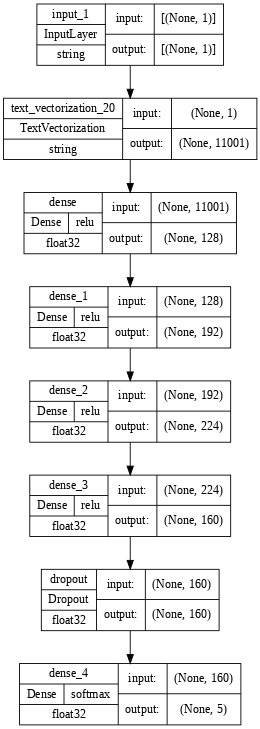

In [97]:
plot_model(model, 
    show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

In [106]:
best_history = new_model.fit(X_train, y_train_encoded, 
                             validation_split=0.2,
                             #validation_data=(X_test, y_test_encoded),
                             epochs=epochs, 
                             batch_size=batch_size,
                             callbacks=callbacks_list, verbose=0)

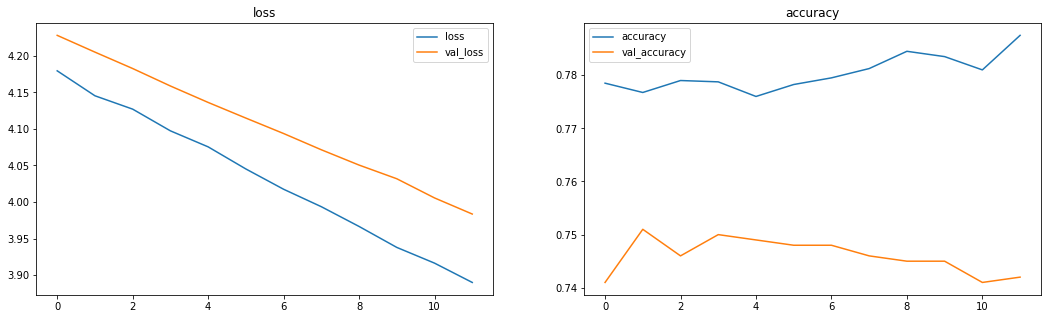

In [107]:
babysit(best_history.history)

32/32 [==============================] - 0s 6ms/step


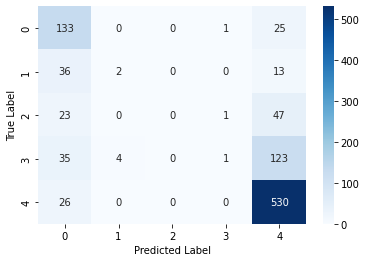

In [108]:
y_pred = np.argmax(model.predict(X_test),axis=1)

y_test = np.argmax(y_test_encoded, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

This is supposed to be the final best model but I am still not satisfies with how it learns, the curves shows that it does not learn so much and the confusion matrix shows that it does not predict well most of the classes.
I really don't know what I did wrong but it is time to submit so I will continue to look for my errors even after submitting the assigment.


Paul Peyssard

MSc Data Science & Artificial Intelligence

Côte d'Azur university
